In [1]:
import datetime

import h5py
import nengo
import numpy as np
import seaborn as sns
import pandas as pd
from nengo.utils.numpy import rmse
import scipy
from scipy import interpolate
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

from constants import *
from process import d3_scale

%matplotlib inline

In [2]:
def bump_func(t):
    return 10 if t < 0.01 else 0

In [50]:
freq = 6.0
period = 1/freq
targ = lambda t: np.sin(2*np.pi*freq*t)

In [75]:
def get_direct_decoders(target_func, arg_osc, bump_func, run_len=2.0):

    with nengo.Network() as train_net:
        bump = nengo.Node(bump_func)
        osc = arg_osc.copy()
        nengo.Connection(bump, osc.ensemble[0])

        p_neur = nengo.Probe(osc.ensemble.neurons, synapse=0.01)
        p_ens = nengo.Probe(osc.ensemble)

    with nengo.Simulator(train_net) as sim_train:
        sim_train.run(run_len)

    solver = nengo.solvers.LstsqL2(reg=0.02)
    start = int(run_len/dt/2)
    end = int(run_len/dt)
    decoders, info = solver(sim_train.data[p_neur][start:end], target_func(np.arange(0, (end-start)*dt, dt))[:, None])
    rmse = info['rmses']

    return decoders, rmse

In [69]:
def run_dd(target_func, period=0.5, seed=0, run_len=2.0, cut_len=1.0):
    with nengo.Network() as dd_model:
        with nengo.Config(nengo.Ensemble) as osc_cfg:
            osc_cfg[nengo.Ensemble].neuron_type = nengo.LIFRate()
            osc_cfg[nengo.Ensemble].seed = seed
            # oscillate at half the period of the actual signal for easier mapping
            osc = nengo.networks.Oscillator(0.1, np.pi/period, 300)

        output = nengo.Node(size_in=1)

        dd, rmse = get_direct_decoders(targ, osc, bump_func)

        bump = nengo.Node(bump_func)
        nengo.Connection(bump, osc.ensemble[0])

        nengo.Connection(osc.ensemble.neurons, output, transform=dd.T)

        p_out = nengo.Probe(output)

    with nengo.Simulator(dd_model) as dd_sim:
        dd_sim.run(run_len)

    res = dd_sim.data[p_out][int(run_len/dt/2):, 0]
    
    return res, rmse

In [37]:
dd_rmse = []
dd_res = []
run_num = 10

for n in range(run_num):
    # hardcoded for 1D
    sig_res, rmse = run_dd(targ, period=period, seed=n)
    dd_res.append(sig_res)
    dd_rmse.append((rmse[0], freq, "Direct DMP"))

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01

In [38]:
ddr = pd.DataFrame(dd_rmse, columns=["RMSE", "Signal Frequency", "Approach"])
dd_res = np.array(dd_res)

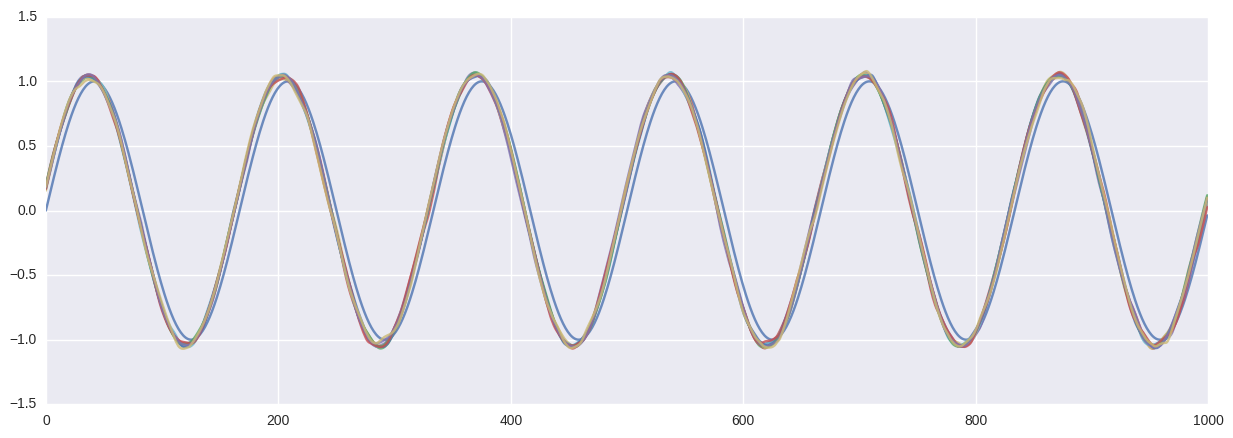

In [39]:
plt.figure(figsize=(15,5))
plt.plot(targ(np.arange(0, dd_res[0].shape[0]*dt, dt)), alpha=0.8)
plt.plot(dd_res.T, alpha=0.8)

In [46]:
ddr.to_hdf("direct_6hz.h5", key='rmse', mode="a")
with h5py.File("direct_6hz.h5", "a") as hf:
    hf.create_dataset("result", data=dd_res)

In [48]:
with h5py.File("direct_6hz.h5", "r") as hf:
    print(hf.items())

[(u'result', <HDF5 dataset "result": shape (10, 1000), type "<f8">), (u'rmse', <HDF5 group "/rmse" (6 members)>)]


# Now let's try it with a 10Hz signal

In [3]:
freq = 10.0
period = 1/freq
targ = lambda t: np.sin(2*np.pi*freq*t)

In [4]:
def get_direct_decoders(target_func, arg_osc, bump_func, run_len=2.0):

    with nengo.Network() as train_net:
        bump = nengo.Node(bump_func)
        osc = arg_osc.copy()
        nengo.Connection(bump, osc.ensemble[0])

        p_neur = nengo.Probe(osc.ensemble.neurons, synapse=0.01)
        p_ens = nengo.Probe(osc.ensemble)

    with nengo.Simulator(train_net) as sim_train:
        sim_train.run(run_len)

    solver = nengo.solvers.LstsqL2(reg=0.02)
    start = int(run_len/dt/2)
    end = int(run_len/dt)
    ens_out = sim_train.data[p_ens][start:end]
    rates = sim_train.data[p_neur][start:end]
    target_out = target_func(np.arange(0, (end-start)*dt, dt))[:, None]
    plt.plot(ens_out)
    plt.plot(target_out)
    decoders, info = solver(rates, target_out)
    rmse = info['rmses']

    return decoders, rmse

In [10]:
def run_dd(target_func, period=0.5, seed=0, run_len=2.0, cut_len=1.0):
    with nengo.Network() as dd_model:
        with nengo.Config(nengo.Ensemble) as osc_cfg:
            osc_cfg[nengo.Ensemble].neuron_type = nengo.LIFRate()
            osc_cfg[nengo.Ensemble].seed = seed
            # oscillate at half the period of the actual signal for easier mapping
            osc = nengo.networks.Oscillator(0.1, np.pi/period/2.0, 300)

        output = nengo.Node(size_in=1)

        dd, rmse = get_direct_decoders(targ, osc, bump_func)

        bump = nengo.Node(bump_func)
        nengo.Connection(bump, osc.ensemble[0])

        nengo.Connection(osc.ensemble.neurons, output, transform=dd.T)

        p_out = nengo.Probe(output)

    with nengo.Simulator(dd_model) as dd_sim:
        dd_sim.run(run_len)

    res = dd_sim.data[p_out][int(run_len/dt/2):, 0]
    
    return res, rmse

In [16]:
freq = 20.0
period = 1/freq
targ = lambda t: np.sin(2*np.pi*freq*t)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01

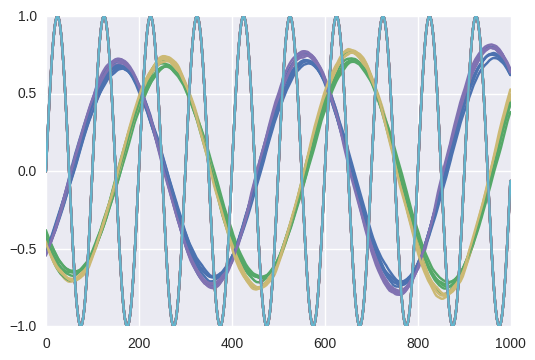

In [11]:
dd_rmse = []
dd_res = []
run_num = 10

for n in range(run_num):
    # hardcoded for 1D
    sig_res, rmse = run_dd(targ, period=period, seed=n)
    dd_res.append(sig_res)
    dd_rmse.append((rmse[0], freq, "Direct DMP"))

In [12]:
ddr = pd.DataFrame(dd_rmse, columns=["RMSE", "Signal Frequency", "Approach"])
dd_res = np.array(dd_res)

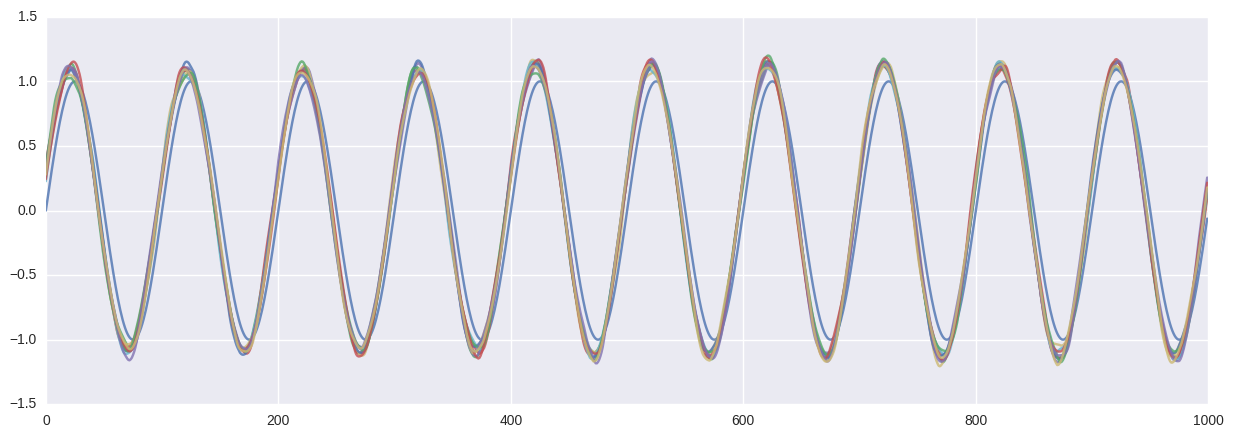

In [13]:
plt.figure(figsize=(15,5))
plt.plot(targ(np.arange(0, dd_res[0].shape[0]*dt, dt)), alpha=0.8)
plt.plot(dd_res.T, alpha=0.8)
#plt.plot(np.mean(dd_res.T, axis=1))

In [14]:
ddr.to_hdf("direct_10hz_2.h5", key='rmse', mode="a")
with h5py.File("direct_10hz_2.h5", "a") as hf:
    hf.create_dataset("result", data=dd_res)

# 2Hz too for reference, I guess

In [83]:
freq = 2.0
period = 1/freq
targ = lambda t: np.sin(2*np.pi*freq*t)

In [84]:
dd_rmse = []
dd_res = []
run_num = 10

for n in range(run_num):
    # hardcoded for 1D
    sig_res, rmse = run_dd(targ, period=period, seed=n)
    dd_res.append(sig_res)
    dd_rmse.append((rmse[0], freq, "Direct DMP"))

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01

In [85]:
ddr = pd.DataFrame(dd_rmse, columns=["RMSE", "Signal Frequency", "Approach"])
dd_res = np.array(dd_res)

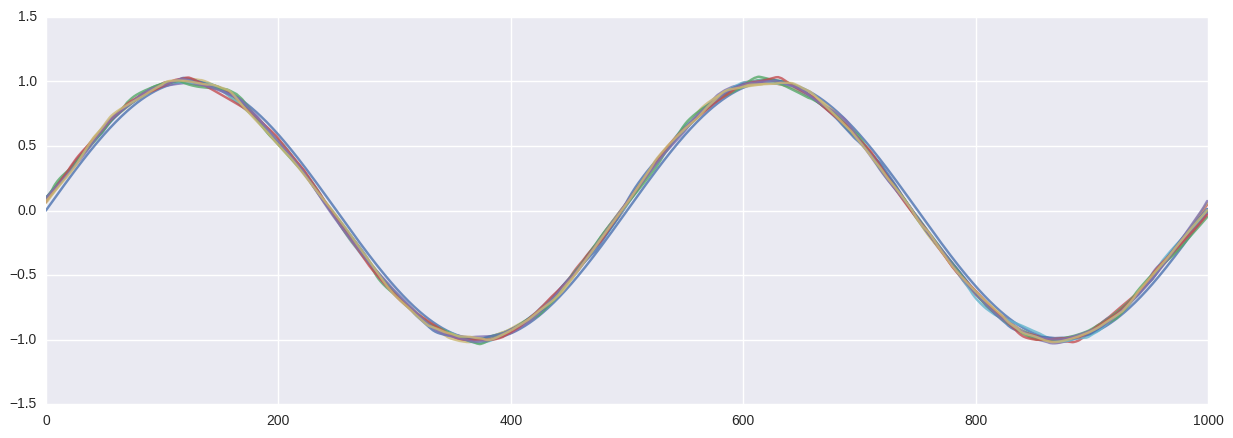

In [86]:
plt.figure(figsize=(15,5))
plt.plot(targ(np.arange(0, dd_res[0].shape[0]*dt, dt)), alpha=0.8)
plt.plot(dd_res.T, alpha=0.8)

In [87]:
ddr.to_hdf("direct_2hz.h5", key='rmse', mode="a")
with h5py.File("direct_2hz.h5", "a") as hf:
    hf.create_dataset("result", data=dd_res)

# 20Hz for lols

In [38]:
freq = 20.0
period = 1/freq
targ = lambda t: np.sin(2*np.pi*freq*t)

In [39]:
def run_dd(target_func, period=0.5, seed=0, run_len=2.0, cut_len=1.0):
    with nengo.Network() as dd_model:
        with nengo.Config(nengo.Ensemble) as osc_cfg:
            osc_cfg[nengo.Ensemble].neuron_type = nengo.LIFRate()
            osc_cfg[nengo.Ensemble].seed = seed
            # oscillate at half the period of the actual signal for easier mapping
            osc = nengo.networks.Oscillator(0.1, np.pi/period/2.0, 600)

        output = nengo.Node(size_in=1)

        dd, rmse = get_direct_decoders(targ, osc, bump_func)

        bump = nengo.Node(bump_func)
        nengo.Connection(bump, osc.ensemble[0])

        nengo.Connection(osc.ensemble.neurons, output, transform=dd.T)

        p_out = nengo.Probe(output)

    with nengo.Simulator(dd_model) as dd_sim:
        dd_sim.run(run_len)

    res = dd_sim.data[p_out][int(run_len/dt/2):, 0]
    
    return res, rmse

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01

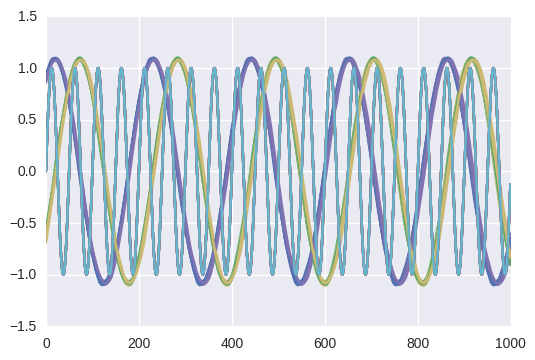

In [40]:
dd_rmse = []
dd_res = []
run_num = 10

for n in range(run_num):
    # hardcoded for 1D
    sig_res, rmse = run_dd(targ, period=period, seed=n)
    dd_res.append(sig_res)
    dd_rmse.append((rmse[0], freq, "Direct DMP"))

In [41]:
ddr = pd.DataFrame(dd_rmse, columns=["RMSE", "Signal Frequency", "Approach"])
dd_res = np.array(dd_res)

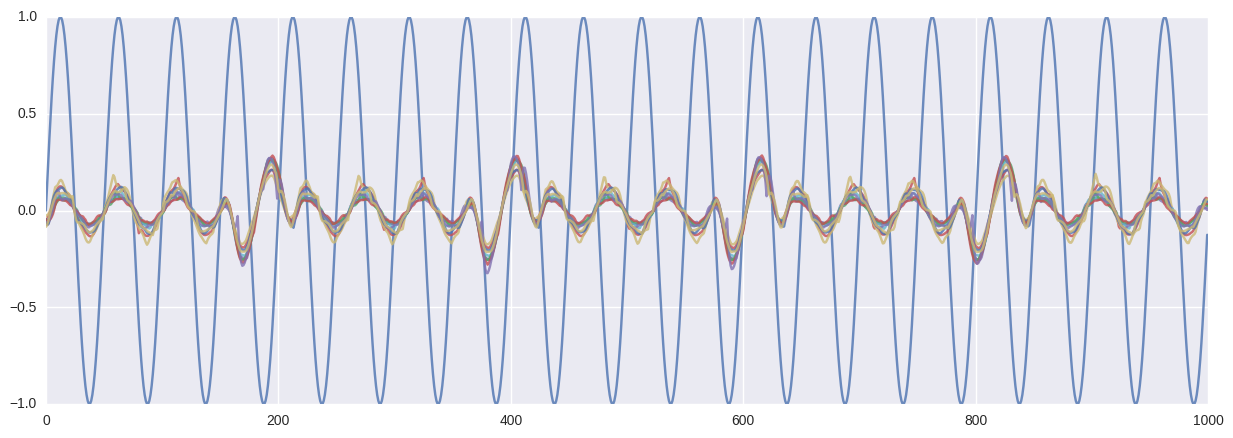

In [42]:
plt.figure(figsize=(15,5))
plt.plot(targ(np.arange(0, dd_res[0].shape[0]*dt, dt)), alpha=0.8)
plt.plot(dd_res.T, alpha=0.8)

In [44]:
ddr.to_hdf("direct_20hz.h5", key='rmse', mode="w")
with h5py.File("direct_20hz.h5", "a") as hf:
    hf.create_dataset("result", data=dd_res)

In [43]:
print(ddr["RMSE"])

0    0.703331
1    0.702726
2    0.703175
3    0.701380
4    0.703114
5    0.702411
6    0.703252
7    0.702922
8    0.702307
9    0.702272
Name: RMSE, dtype: float64


# okay 15hz too

In [29]:
freq = 15.0
period = 1/freq
targ = lambda t: np.sin(2*np.pi*freq*t)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 
Building finished in 0:00:01

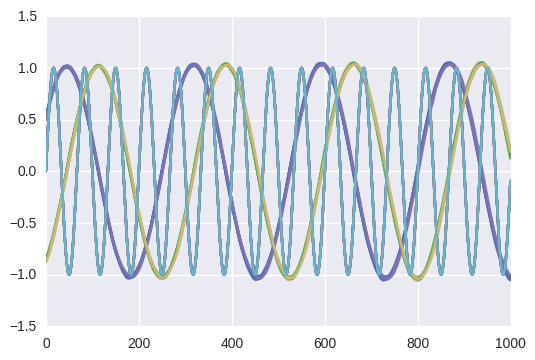

In [30]:
dd_rmse = []
dd_res = []
run_num = 10

for n in range(run_num):
    # hardcoded for 1D
    sig_res, rmse = run_dd(targ, period=period, seed=n)
    dd_res.append(sig_res)
    dd_rmse.append((rmse[0], freq, "Direct DMP"))

In [31]:
ddr = pd.DataFrame(dd_rmse, columns=["RMSE", "Signal Frequency", "Approach"])
dd_res = np.array(dd_res)

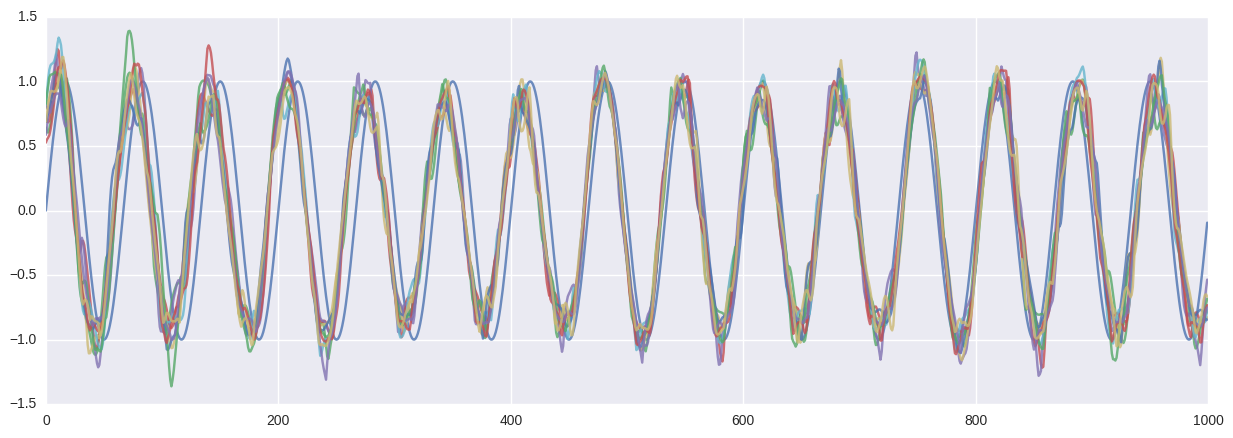

In [32]:
plt.figure(figsize=(15,5))
plt.plot(targ(np.arange(0, dd_res[0].shape[0]*dt, dt)), alpha=0.8)
plt.plot(dd_res.T, alpha=0.8)

In [33]:
ddr.to_hdf("direct_15hz.h5", key='rmse', mode="a")
with h5py.File("direct_15hz.h5", "a") as hf:
    hf.create_dataset("result", data=dd_res)